In [72]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
print("Shape of data:", df.shape)
print("\nInfo:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

print("\nTarget value counts:")
print(df['Churn'].value_counts())


Shape of data: (7043, 21)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paperless

In [74]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

df.drop("customerID", axis=1, inplace=True)

binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

df = pd.get_dummies(df, columns=[
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
], drop_first=True)



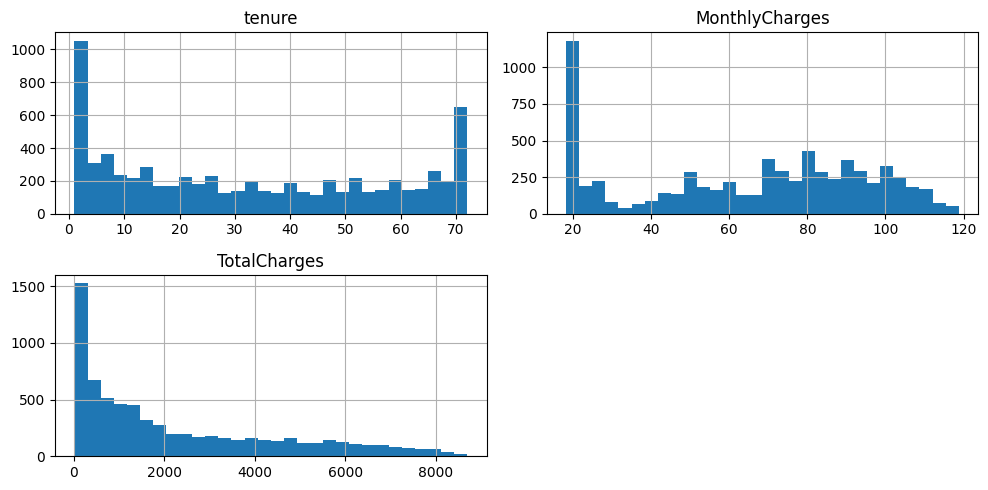

In [75]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df[num_features].hist(figsize=(10, 5), bins=30)
plt.tight_layout()
plt.show()


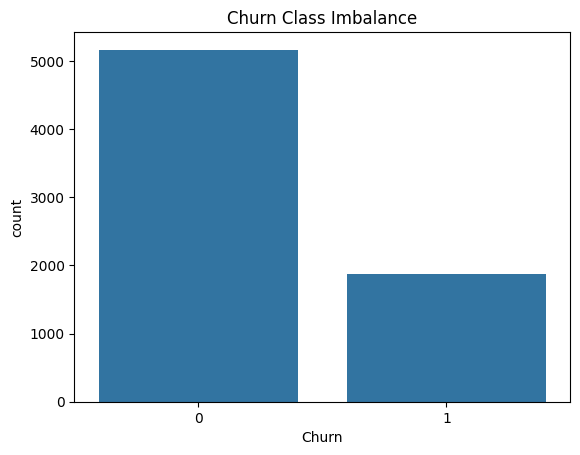

Top correlations with churn:
Churn                             1.000000
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
MonthlyCharges                    0.192858
PaperlessBilling                  0.191454
SeniorCitizen                     0.150541
StreamingTV_Yes                   0.063254
StreamingMovies_Yes               0.060860
MultipleLines_Yes                 0.040033
PhoneService                      0.011691
Name: Churn, dtype: float64


In [76]:
# Class balance
sns.countplot(x='Churn', data=df)
plt.title('Churn Class Imbalance')
plt.show()

# Correlation with target
correlation = df.corr()['Churn'].sort_values(ascending=False)
print("Top correlations with churn:")
print(correlation.head(10))


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

X = df.drop('Churn', axis=1)
y = df['Churn']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [79]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_proba = lr.predict_proba(X_test_scaled)[:,1]

svm = SVC(kernel='linear', class_weight='balanced', probability=True)
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)
svm_proba = svm.predict_proba(X_test_scaled)[:,1]

nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
nb_pred = nb.predict(X_test_scaled)
nb_proba = nb.predict_proba(X_test_scaled)[:,1]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)
knn_proba = knn.predict_proba(X_test_scaled)[:,1]



In [80]:
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n📊 {name} Evaluation Metrics:")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_true, y_proba))


In [81]:
evaluate_model("Logistic Regression", y_test, lr_pred, lr_proba)
evaluate_model("Support Vector Machine", y_test, svm_pred, svm_proba)
evaluate_model("Naive Bayes", y_test, nb_pred, nb_proba)
evaluate_model("KNN", y_test, knn_pred, knn_proba)



📊 Logistic Regression Evaluation Metrics:
[[724 309]
 [ 76 298]]
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407

ROC-AUC Score: 0.8349765233911922

📊 Support Vector Machine Evaluation Metrics:
[[661 372]
 [ 69 305]]
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      1033
           1       0.45      0.82      0.58       374

    accuracy                           0.69      1407
   macro avg       0.68      0.73      0.67      1407
weighted avg       0.78      0.69      0.70      1407

ROC-AUC Score: 0.817013164501918

📊 Naive Bayes Evaluation Metrics:
[[584 449]
 [ 51 323]]
              precision    recall  f1-score   support

           0       0.92      0.

In [82]:
results = {
    'Model': ['Logistic Regression', 'SVM', 'Naive Bayes', 'KNN'],
    'ROC-AUC': [
        roc_auc_score(y_test, lr_proba),
        roc_auc_score(y_test, svm_proba),
        roc_auc_score(y_test, nb_proba),
        roc_auc_score(y_test, knn_proba)
    ]
}

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='ROC-AUC', ascending=False))


                 Model   ROC-AUC
0  Logistic Regression  0.834977
1                  SVM  0.817013
2          Naive Bayes  0.810182
3                  KNN  0.767047


In [83]:
# logistic performs well by comparing to other models
# lets get top features
# Assuming X_train.columns and model is already trained


feature_names = X_train.columns
coefficients = lr.coef_[0]

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

# Sort by absolute importance
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Show top 15 features
importance_df.head(15)


,Feature,Coefficient,Abs_Coefficient
4,tenure,-1.263854,1.263854
7,MonthlyCharges,-0.928682,0.928682
11,InternetService_Fiber optic,0.746144,0.746144
26,Contract_Two year,-0.638598,0.638598
8,TotalCharges,0.623279,0.623279
25,Contract_One year,-0.326693,0.326693
22,StreamingTV_Yes,0.259691,0.259691
24,StreamingMovies_Yes,0.252870,0.252870
10,MultipleLines_Yes,0.202763,0.202763
28,PaymentMethod_Electronic check,0.193697,0.193697


/tmp/ipython-input-84-121790388.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Abs_Coefficient', y='Feature', data=top_features, palette='viridis')


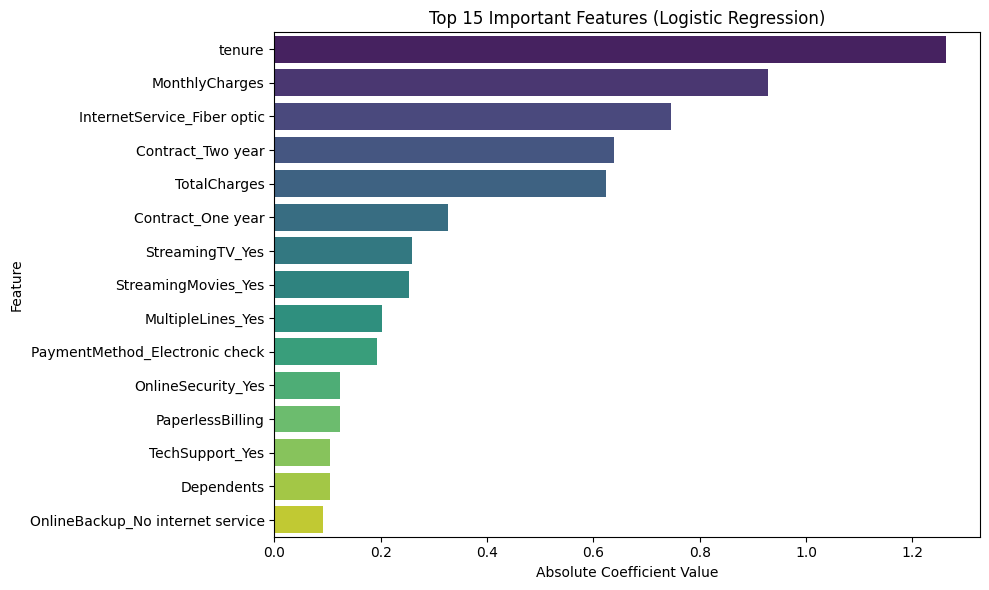

In [84]:


top_features = importance_df.head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='Abs_Coefficient', y='Feature', data=top_features, palette='viridis')
plt.title("Top 15 Important Features (Logistic Regression)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
